In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d import Axes3D
import string
import copy

In [2]:
%matplotlib inline

In [3]:
color_list = ['g', 'r', 'c', 'm', 'y'] + 20*['k']

In [4]:
boxdf = pd.read_csv('box.csv')
proddf = pd.read_csv('sku.csv')

In [5]:
# add columns with shorter names
boxdf['w'] = boxdf['Box_width (in)']
boxdf['l'] = boxdf['Box_length (in)']
boxdf['h'] = boxdf['Box_height (in)']
proddf['w'] = proddf['Width (in)']
proddf['l'] = proddf['Length (in)']
proddf['h'] = proddf['Height (in)']
proddf['weight'] = proddf['Weight (oz)']

# add volume and surface area columns
boxdf['v'] = boxdf.w*boxdf.l*boxdf.h
boxdf['sa'] = 2*boxdf.w*boxdf.l + 2*boxdf.w*boxdf.h + 2*boxdf.h*boxdf.l
proddf['v'] = proddf.w*proddf.l*proddf.h
proddf['sa'] = 2*proddf.w*proddf.l + 2*proddf.w*proddf.h + 2*proddf.h*proddf.l

# remove the two prods without dim
proddf = proddf[pd.notnull(proddf.w)]

In [6]:
def get_order(size_range=xrange(2,5)):
    '''Randomly pick a number of products.'''
    return proddf.loc[np.random.choice(proddf.index, np.random.choice(size_range))]

In [37]:
def optimal_pack(orderdf, boxdf=boxdf, inter=True):
    '''Find a way to pack a list of products in a order box, optimizing for the smallest order box surface area.'''
    
    # get the total volume and maximum dimensions of the products
    tot_vol = max(orderdf.v)
    max_w = max(orderdf.w)
    max_l = max(orderdf.l)
    max_h = max(orderdf.h)
    
    # order the products by surface area
    orderdf = orderdf.sort('sa', ascending=False)
    
   
    # step through the order boxes, from smallest surface area to largest
    for boxindex in boxdf.index:
        box = boxdf.loc[boxindex]

        # check to make sure the volume of the box is at least the total volume of the products,
        # and the dimensions are at least the maximum dimensions of the products
        if box.v < tot_vol or box.w < max_w or box.l < max_l or box.h < max_h:
            continue
            
        # initialize the list of corners
        corners = [(0, 0, 0)]
        
        # a history of the corners list
        corners_history = [copy.copy(corners)]
        
        
        # set the list of packed products to empty list
        pack_list = []
            
        # step through the product list from largest surface area to largest
        for prodindex in orderdf.index:
            prod = proddf.loc[prodindex]
            
            # set the corner to None
            corner = None

            # step through the corner list, seeing where the product fits
            for c in corners:
                
                # does prod fit at c?
                # 1. does it fit in box?
                if box.l < c[0] + prod.l or box.w < c[1] + prod.l or box.h < c[2] + prod.h:
                    continue
                
                # 2. does it intersect with any of the products already in the box?
                if inter and intersects_packed(prod, c, pack_list):
                    continue
                
                else:
                    corner = c
                    break

            if corner:
                pack_list.append([prodindex, corner])
                corners.remove(corner)
                corners.append((corner[0] + prod.l, corner[1], corner[2]))
                corners.append((corner[0], corner[1] + prod.w, corner[2]))
                corners.append((corner[0], corner[1], corner[2] + prod.h))
                corners_history.append(copy.copy(corners))
            else:
                break

        if len(pack_list) < len(orderdf):
             continue
        return tot_vol, max_w, max_l, max_h, boxindex, pack_list, corners_history

In [38]:
# drawing
def draw_packing(ax, boxindex, pack_list):
    
    # draw the order box
    box = boxdf.loc[boxindex]
    draw_box(ax, l = box.l, w = box.w, h = box.h)
    
    # step through the pack_list
    for ind, [prodindex, corner] in enumerate(pack_list):
        prod = proddf.loc[prodindex]
        draw_box(ax, l = prod.l, w = prod.w, h = prod.h, x = corner[0], y = corner[1], z = corner[2], col=color_list[ind])
        
def draw_box(ax, l = 1, w = 1, h = 1, x = 0, y = 0, z = 0, col='b'):

    ax.plot([x, x + l], [y, y], [z, z], color = col)
    ax.plot([x, x + l], [y + w, y + w], [z, z], color = col)
    ax.plot([x, x + l], [y, y], [z + h, z + h], color = col)
    ax.plot([x, x + l], [y + w, y + w], [z + h, z + h], color = col)
    
    ax.plot([x, x], [y, y + w], [z, z], color = col)
    ax.plot([x, x], [y, y + w], [z + h, z + h], color = col)
    ax.plot([x + l, x + l], [y, y + w], [z, z], color = col)
    ax.plot([x + l, x + l], [y, y + w], [z + h, z + h], color = col)
    
    ax.plot([x, x], [y, y], [z, z + h], color = col)
    ax.plot([x + l, x + l], [y, y], [z, z + h], color = col)
    ax.plot([x, x], [y + w, y + w], [z, z + h], color = col)
    ax.plot([x + l, x + l], [y + w, y + w], [z, z + h], color = col)

In [39]:
lwh = ['l', 'w', 'h']

In [40]:
def intersects_packed(prod, corner, pack_list):
    for prodindex, corner2 in pack_list:
        prod2 = proddf.loc[prodindex]
        if prods_intersect(prod, corner, prod2, corner2):
            return True
    return False

def prods_intersect(prod1, corner1, prod2, corner2):
    a = np.prod([ranges_intersect(
                corner1[i],
                corner1[i] + prod1[lwh[i]],
                corner2[i],
                corner2[i] + prod2[lwh[i]]
                ) for i in [0,1,2]])
    return a

def ranges_intersect(s1, s2, t1, t2):
    return (s1 <= t1 and t1 < s2) or (t1 < s1 and s1 < t2)

In [69]:
o = get_order(size_range=[3])
tot_vol, max_w, max_l, max_h, boxindex, pack_list, corners_history = optimal_pack(o)
print tot_vol, max_w, max_l, max_h, boxindex, pack_list, [len(i) for i in corners_history]

416.25 9.0 9.25 5.0 1 [[199, (0, 0, 0)], [331, (9.25, 0, 0)], [268, (9.25, 3.5, 0)]] [1, 3, 5, 7]


In [70]:
boxdf.loc[boxindex]

Box                     B2
Box_length (in)       16.5
Box_width (in)          11
Box_height (in)        6.5
w                       11
l                     16.5
h                      6.5
v                  1179.75
sa                   720.5
Name: 1, dtype: object

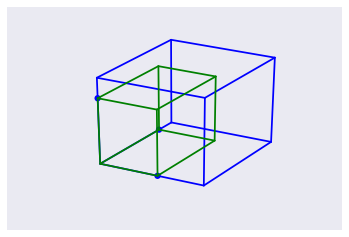

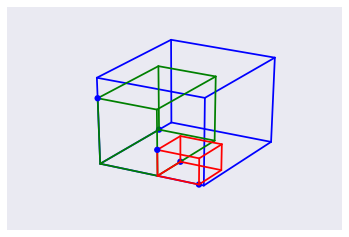

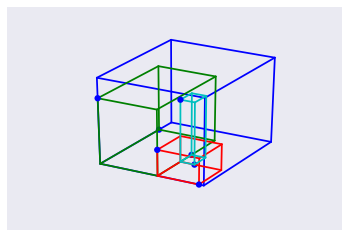

In [76]:
for j in xrange(len(pack_list)):
    fig = plt.figure()
    ax  = fig.add_subplot(111, projection = '3d')
    draw_packing(ax, boxindex, pack_list[:j+1])
    #draw_corners(ax, corners_history[j])
    for corner in corners_history[j + 1]:
        ax.scatter(*corner, s=40, edgecolors='none', alpha=1, depthshade=False)
    plt.axis('off')
    filenamestring = string.join(['{}_'.format(i) for i in zip(*pack_list)[0]], '')+'{}'.format(boxindex)
    fig.savefig('anpic'+filenamestring+'_{}.png'.format(j), bbox='tight', dpi=300)

In [72]:
pack_list

[[199, (0, 0, 0)], [331, (9.25, 0, 0)], [268, (9.25, 3.5, 0)]]

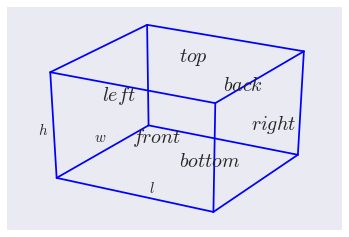

In [68]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection = '3d')
draw_box(ax)
#draw_packing(ax, boxindex, pack_list)
plt.axis('off')
#filenamestring = string.join(['{}_'.format(i) for i in zip(*pack_list)[0]], '')+'{}'.format(boxindex)
#fig.savefig('pic'+filenamestring+'.png', bbox='tight', dpi=300)
ax.text(0.6, 0, 0.05, r'$l$', size=15)
ax.text(0, 0.4, 0.15, r'$w$', size=15)
ax.text(0, -0.15, 0.5, r'$h$', size=15)
ax.text(0.5, 0.5, 0, r'$bottom$', size=20)
ax.text(0.5, 0.5, 1, r'$top$', size=20)
ax.text(0.5, 0, 0.5, r'$front$', size=20)
ax.text(0.5, 1, 0.5, r'$back$', size=20)
ax.text(0, 0.5, 0.5, r'$left$', size=20)
ax.text(0.95, 0.5, 0.5, r'$right$', size=20)
fig.savefig('box.png', bbox='tight', dpi=300)

In [436]:
string.join(['a','b'], '')

'ab'

In [375]:
zip(*pack_list)

[(385, 318, 134), ((0, 0, 0), (0, 0, 4.5), (11.5, 0, 0))]

In [235]:
try:
    for i in xrange(100):
        o = get_order(size_range=[6])
        optimal_pack(o)
except:
    print o

In [227]:
o

,SKU,Weight (oz),Length (in),Width (in),Height (in),w,l,h,weight,v,sa
351,SKU-352,17.6,10.000,8.700,3.600,8.700,10.000,3.600,17.6,313.200000,308.64000
312,SKU-313,32.0,10.000,6.850,4.680,6.850,10.000,4.680,32.0,320.580000,294.71600
200,SKU-201,44.0,8.000,9.500,5.000,9.500,8.000,5.000,44.0,380.000000,327.00000
297,SKU-298,30.0,6.625,6.625,9.125,6.625,6.625,9.125,30.0,400.501953,329.59375
296,SKU-297,37.0,6.625,6.625,9.125,6.625,6.625,9.125,37.0,400.501953,329.59375
296,SKU-297,37.0,6.625,6.625,9.125,6.625,6.625,9.125,37.0,400.501953,329.59375


In [231]:
optimal_pack(o)

(400.501953125,
 9.5,
 10.0,
 9.125,
 8,
 [[297, (0, 0, 0)],
  [296, (6.625, 0, 0)],
  [296, (0, 6.625, 0)],
  [200, (13.25, 0, 0)],
  [351, (13.25, 9.5, 0)],
  [312, (13.25, 0, 5.0)]])

In [260]:
with_intersect = [optimal_pack(get_order(size_range=[6])) for i in xrange(2000)]

In [261]:
len([i for i in with_intersect if not i])

107

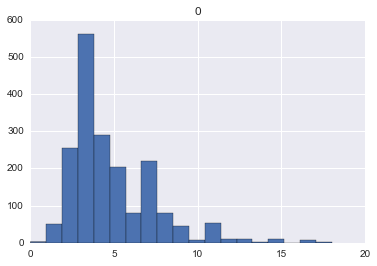

In [262]:
pd.DataFrame([i[-2] for i in with_intersect if i]).hist(bins=19)
plt.savefig('1.png')

In [263]:
without_intersect = [optimal_pack(get_order(size_range=[6]), inter=False) for i in xrange(2000)]

In [264]:
len([i for i in without_intersect if not i])

123

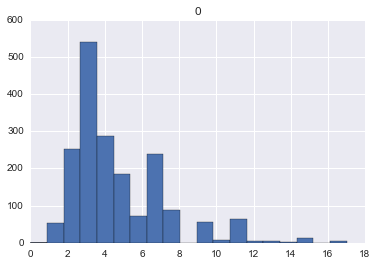

In [265]:
pd.DataFrame([i[-2] for i in without_intersect if i]).hist(bins=19)
plt.savefig('2.png')